# Forecasting using ARIMA, SARIMAX, ExponentialSmoothening

**Import Libraries and Dataset**

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [135]:
df = pd.read_csv('Champagne Sales Data.csv')

In [136]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [137]:
df.rename(columns = {'Perrin Freres monthly champagne sales millions ?64-?72' : 'monthly_champagne_sales'}, inplace = True)

In [138]:
df.head()

,Month,monthly_champagne_sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


**Basic EDA**

In [139]:
df.describe()

,monthly_champagne_sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


Text(0, 0.5, 'Monthly sales in millions')

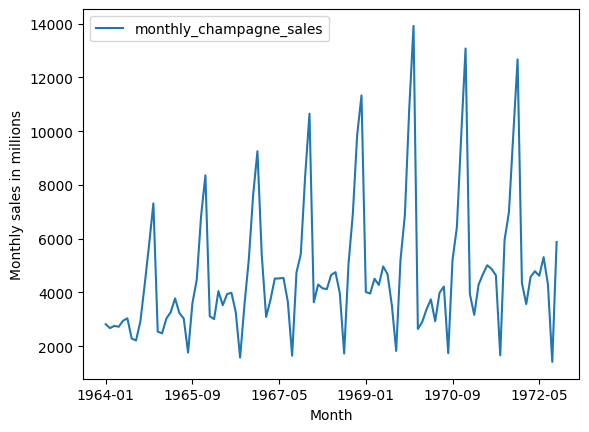

In [140]:
df.plot(x = 'Month', y = 'monthly_champagne_sales', kind = 'line')
plt.ylabel('Monthly sales in millions')

In [141]:
df.isnull().sum()

Month                      0
monthly_champagne_sales    0
dtype: int64

In [142]:
df['Month'] = pd.to_datetime(df['Month'])

In [143]:
df.dtypes

Month                      datetime64[ns]
monthly_champagne_sales             int64
dtype: object

**Statistical Test to Check Stationarity**

In [144]:
adf_result = adfuller(df['monthly_champagne_sales'])

In [145]:
def adf_test(result):
    result = adfuller(result)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for labels, result_print in zip(labels, result):
        print(labels + ':' + str(result_print))
    if result[1] <= 0.05:
        print('Series is stationary. Null Hypothesis rejected')
    else:
        print('Series is non-stationary. Null Hypothesis cant be rejected')

In [146]:
adf_test(df['monthly_champagne_sales'])

ADF Test Statistic:-1.8335930563276246
p-value:0.3639157716602442
#Lags Used:11
Number of Observations Used:93
Series is non-stationary. Null Hypothesis cant be rejected


**Series is Stationary**

First difference and the seasonal first difference

In [147]:
df['First Difference'] = df['monthly_champagne_sales'] - df['monthly_champagne_sales'].shift(1)
df['Seasonal First Difference'] = df['monthly_champagne_sales'] - df['monthly_champagne_sales'].shift(12)

In [148]:
df.head(15)

,Month,monthly_champagne_sales,First Difference,Seasonal First Difference
0,1964-01-01,2815,NaN,NaN
1,1964-02-01,2672,-143.0,NaN
2,1964-03-01,2755,83.0,NaN
3,1964-04-01,2721,-34.0,NaN
4,1964-05-01,2946,225.0,NaN
5,1964-06-01,3036,90.0,NaN
6,1964-07-01,2282,-754.0,NaN
7,1964-08-01,2212,-70.0,NaN
8,1964-09-01,2922,710.0,NaN
9,1964-10-01,4301,1379.0,NaN


In [149]:
adf_test(df['First Difference'].dropna())

ADF Test Statistic:-7.189896448051026
p-value:2.519620447386696e-10
#Lags Used:11
Number of Observations Used:92
Series is stationary. Null Hypothesis rejected


In [150]:
adf_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic:-7.626619157213164
p-value:2.060579696813685e-11
#Lags Used:0
Number of Observations Used:92
Series is stationary. Null Hypothesis rejected


**Both Differences are Stationary**

<Axes: >

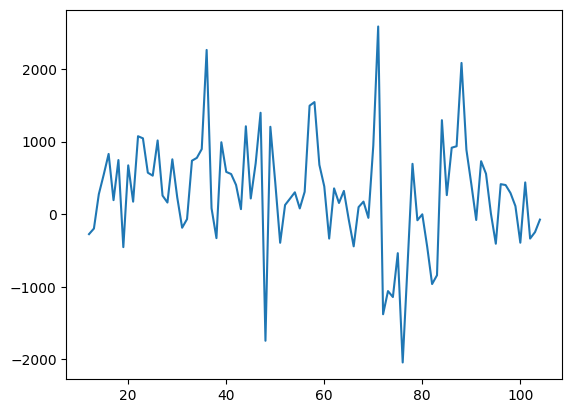

In [151]:
df['Seasonal First Difference'].plot(kind = 'line')

Visualize the autocorrelation 

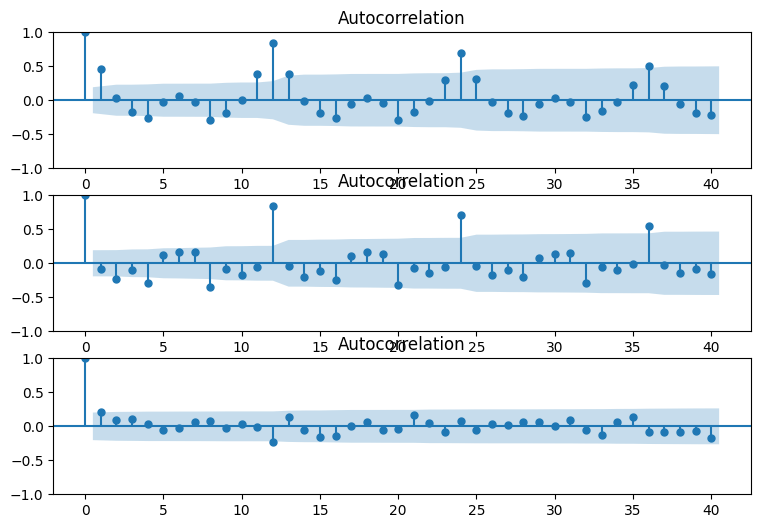

In [152]:
fig = plt.figure(figsize = (9,6))
ax1 = fig.add_subplot(311)
fig = sm.graphics.tsa.plot_acf(df['monthly_champagne_sales'], lags = 40, ax = ax1)
ax2 = fig.add_subplot(312)
fig = sm.graphics.tsa.plot_acf(df['First Difference'].dropna(), lags = 40, ax = ax2)
ax3 = fig.add_subplot(313)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].dropna(), lags = 40, ax = ax3)

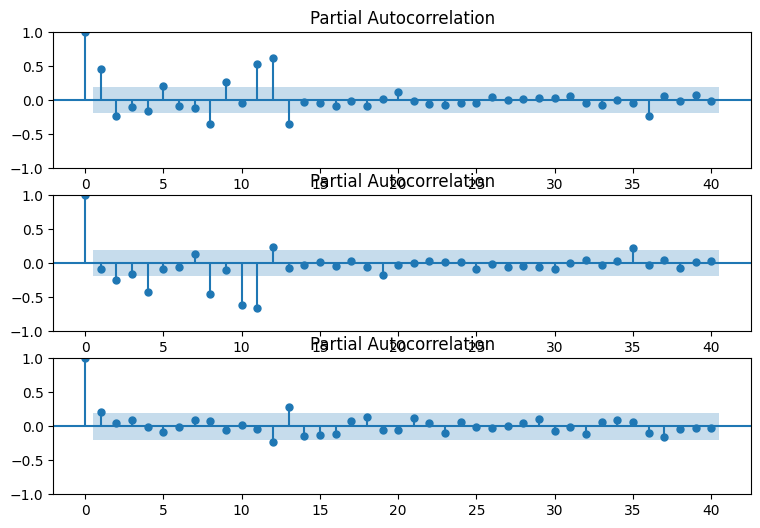

In [153]:
fig = plt.figure(figsize = (9,6))
ax1 = fig.add_subplot(311)
fig = sm.graphics.tsa.plot_pacf(df['monthly_champagne_sales'], lags = 40, ax = ax1)
ax2 = fig.add_subplot(312)
fig = sm.graphics.tsa.plot_pacf(df['First Difference'].dropna(), lags = 40, ax = ax2)
ax3 = fig.add_subplot(313)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].dropna(), lags = 40, ax = ax3)

**TSA using ARIMA**

In [154]:
model = sm.tsa.ARIMA(df['monthly_champagne_sales'], order = (1,1,1))
arima_model = model.fit()

In [155]:
print(arima_model.summary())

                                  SARIMAX Results                                  
Dep. Variable:     monthly_champagne_sales   No. Observations:                  105
Model:                      ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                     Thu, 23 May 2024   AIC                           1911.627
Time:                             01:08:49   BIC                           1919.560
Sample:                                  0   HQIC                          1914.841
                                     - 105                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      3.999      0.000       0.232       0.677
ma.L1         -0.9666      0.056    -17.316      0.000      -1.076      -0.857
sigma2      

**Model tried with different lag values**

In [156]:
model3 = sm.tsa.ARIMA(df['monthly_champagne_sales'], order = (3,1,1))
arima_model_3 = model3.fit()
print(arima_model_3.summary())

                                  SARIMAX Results                                  
Dep. Variable:     monthly_champagne_sales   No. Observations:                  105
Model:                      ARIMA(3, 1, 1)   Log Likelihood                -948.467
Date:                     Thu, 23 May 2024   AIC                           1906.934
Time:                             01:08:50   BIC                           1920.156
Sample:                                  0   HQIC                          1912.290
                                     - 105                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5128      0.124      4.146      0.000       0.270       0.755
ar.L2         -0.1961      0.215     -0.914      0.361      -0.617       0.224
ar.L3       

The model with order = (1,1,1) is a good fit

**Plot ARIMA**

In [157]:
df['Forecast Values'] = arima_model.predict(start = 90, end = 115, dynamic = True)

<Axes: >

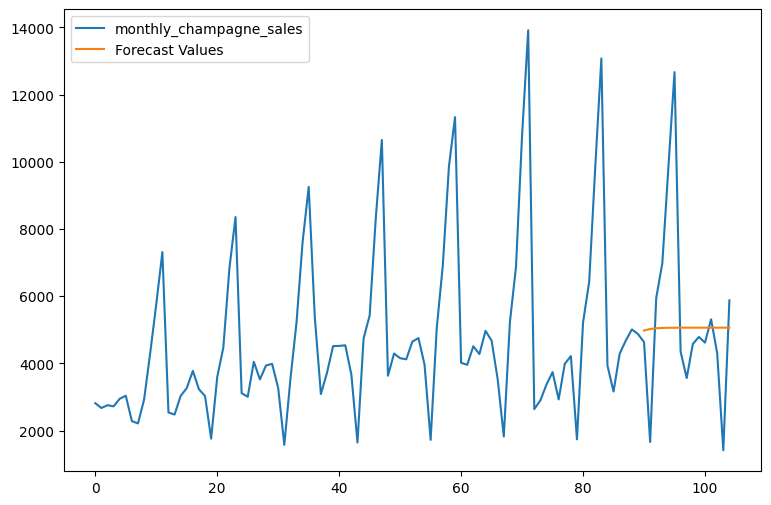

In [158]:
df[['monthly_champagne_sales', 'Forecast Values']].plot(figsize=(9, 6), kind='line')

**SARIMAX Model to account for Seasonality**

<Axes: >

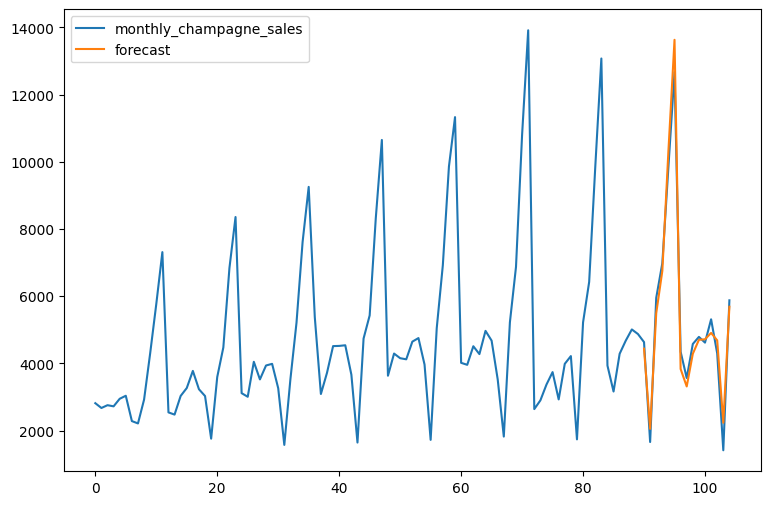

In [159]:
sarimax_model = sm.tsa.statespace.SARIMAX(df['monthly_champagne_sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
sarimax_results = sarimax_model.fit()
df['forecast']=sarimax_results.predict(start=90,end=106,dynamic=True)
df[['monthly_champagne_sales','forecast']].plot(figsize=(9,6))

**ExponentialSmoothing and seasonal_decompose Forecast Model**

In [160]:
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [161]:
model_exp_smoothing = ExponentialSmoothing(df['monthly_champagne_sales'], trend='add', seasonal='add', seasonal_periods=12)
exp_smoothing_results = model_exp_smoothing.fit()
print(exp_smoothing_results.summary())

                         ExponentialSmoothing Model Results                        
Dep. Variable:     monthly_champagne_sales   No. Observations:                  105
Model:                ExponentialSmoothing   SSE                       50431691.406
Optimized:                            True   AIC                           1405.628
Trend:                            Additive   BIC                           1448.091
Seasonal:                         Additive   AICC                          1413.581
Seasonal Periods:                       12   Date:                 Thu, 23 May 2024
Box-Cox:                             False   Time:                         01:08:51
Box-Cox Coeff.:                       None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0757938                alpha                 Tru

Forecast plot for ExponentialSmoothing

<Axes: >

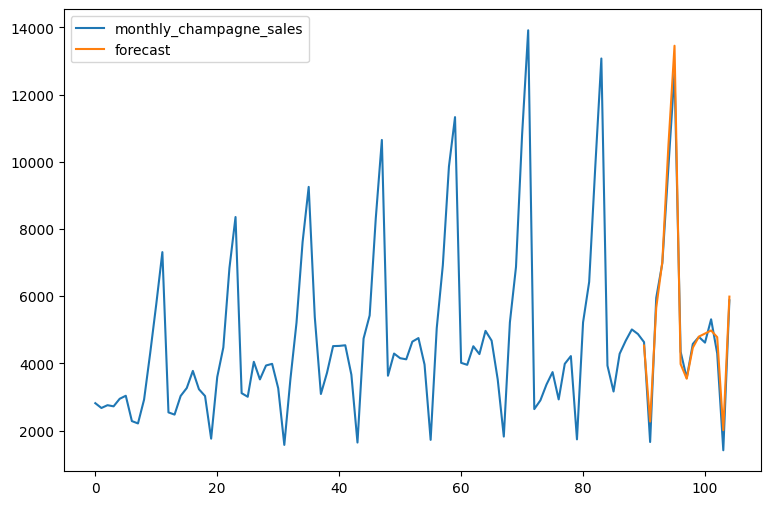

In [162]:
df['forecast'] = exp_smoothing_results.predict(start=90, end=106)
df[['monthly_champagne_sales','forecast']].plot(figsize=(9,6))

**Future value Forecasts**

In [163]:
from pandas.tseries.offsets import DateOffset

In [164]:
 #df.head()

In [165]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

Create future dates DataFrame

In [166]:
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1, 24)]
future_datest_df = pd.DataFrame(index=future_dates, columns=df.columns)
future_df = pd.concat([df, future_datest_df])

C:\Users\weroc\AppData\Local\Temp\ipykernel_6864\1001367240.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df = pd.concat([df, future_datest_df])


**SARIMAX Model** for Future values

C:\Users\weroc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\weroc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


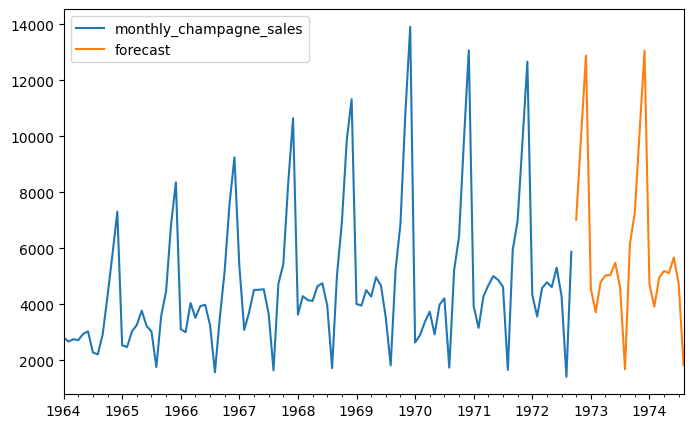

In [167]:
model = SARIMAX(df['monthly_champagne_sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()
future_df['forecast'] = results.predict(start=len(df), end=len(df) + len(future_datest_df) - 1, dynamic=True)

# Plot the original and forecasted values
future_df[['monthly_champagne_sales', 'forecast']].plot(figsize=(8, 5))
plt.show()

**Model Robustness**

In-Sample Evaluation

In [168]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

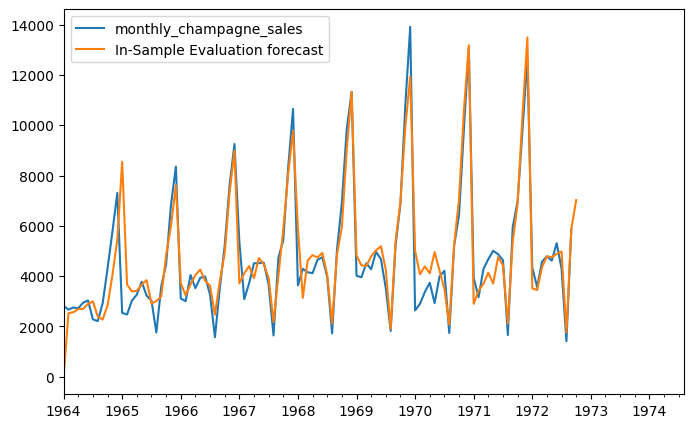

In [169]:
future_df['In-Sample Evaluation forecast'] = results.predict(start=0, end=len(df), dynamic=False)

# Plot the original and forecasted values
future_df[['monthly_champagne_sales', 'In-Sample Evaluation forecast']].plot(figsize=(8, 5))
plt.show()

In [170]:
actual_values = future_df['monthly_champagne_sales'].dropna()
forecasted_values = future_df['In-Sample Evaluation forecast'].dropna()

In [171]:
# Identify the problematic timestamp
problematic_timestamp = pd.Timestamp('1972-10-01 00:00:00')

# Remove the problematic timestamp from forecasted_values if it exists
if problematic_timestamp in forecasted_values.index:
    forecasted_values = forecasted_values.drop(problematic_timestamp)

# Align indices after removing the problematic timestamp
actual_values_aligned = actual_values.loc[forecasted_values.index]


**Model Robustness metrics**

In [172]:
# Calculate MAE, MSE, RMSE
mae = mean_absolute_error(actual_values_aligned, forecasted_values)
mse = mean_squared_error(actual_values_aligned, forecasted_values)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 638.6493590095062
MSE: 988527.2380529266
RMSE: 994.2470709300212


**Out-of-sample predictions** <br>
Training SARIMAX model on 80% dataset

In [173]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Fit model on training data
model = SARIMAX(train['monthly_champagne_sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()


test['forecast'] = results.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=True)

# Calculate MAE, MSE, RMSE
mae = mean_absolute_error(test['monthly_champagne_sales'], test['forecast'])
mse = mean_squared_error(test['monthly_champagne_sales'], test['forecast'])
rmse = np.sqrt(mse)

print(f'Out-of-sample MAE: {mae}')
print(f'Out-of-sample MSE: {mse}')
print(f'Out-of-sample RMSE: {rmse}')


C:\Users\weroc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\weroc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Out-of-sample MAE: 1024.0797586888182
Out-of-sample MSE: 1410610.110208384
Out-of-sample RMSE: 1187.6910836612287


C:\Users\weroc\AppData\Local\Temp\ipykernel_6864\47641576.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['forecast'] = results.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=True)


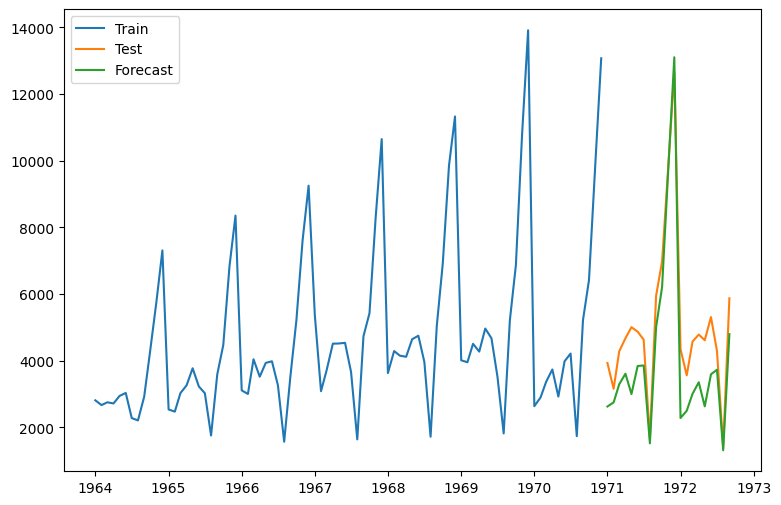

In [174]:
# Plot the results
plt.figure(figsize=(9, 6))
plt.plot(train['monthly_champagne_sales'], label='Train')
plt.plot(test['monthly_champagne_sales'], label='Test')
plt.plot(test['forecast'], label='Forecast')
plt.legend(loc='best')
plt.show()

**Thank You**